# LSTM and GRU Models for PTB data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling  
rescaling: Standard

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
Input file:(The preprocessed data)     
ptb_train_clean_standard_oversampling.csv (Standard Scaled data)  
ptb_test_clean_standard_oversampling.csv  (Standard Sscaled data)   

Output: lstm model trained  
model_ptb_lstm.pkl  

| **Feature**                     | **LSTM**                                                      | **GRU**                                                 |
|---------------------------------|---------------------------------------------------------------|---------------------------------------------------------|
| **Types of Gates**              | 3 gates: Input, Forget, Output                                | 2 gates: Update, Reset                                  |
| **Memory Structure**            | Keeps two kinds of memory: cell and hidden                    | Only one memory type: hidden                            |
| **Computational Demand**        | Uses more power and memory                                    | Uses less power and memory                              |
| **Training Speed**              | Takes more time to train                                      | Trains faster                                           |
| **Best for Long Sequences**     | Great for remembering long sequences and details              | Good for simpler, shorter sequences                     |
| **When to Use**                 | When you need to remember a lot of details over a long period | When you want quicker training with fewer details       |


In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax


RawFiles = dict({
    'train': data_path + 'ptb_train_clean_standard_oversampling.csv', 
    'test': data_path + 'ptb_test_clean_standard_oversampling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_ptb_lstm.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [4]:
X_train.shape[0]

16756

In [5]:
X_train.shape[1]

187

# LSTM with Standard Scaler and Oversampling

In [ ]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # samples, timesteps, features
print("X_test shape:", X_test.shape)    # samples, timesteps, features


X_train shape: (16756, 187, 1)
X_test shape: (2911, 187, 1)


## Subsample

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the subsample fraction
sample_fraction = 0.2

# Create a random sample of indices for subsampling
sample_indices = np.random.choice(len(X_train), size=int(len(X_train) * sample_fraction), replace=False)
X_train_sample = X_train[sample_indices]
y_train_sample = y_train[sample_indices]

# Define LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_sample.shape[1], X_train_sample.shape[2])))
model.add(LSTM(187, activation='relu', return_sequences=True))

# Hidden layers
model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.3))

# Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)

# Lists to store metrics over epochs
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size and number of epochs
batch_size = 32
epochs = 50

# Training loop on the subsample
for epoch in range(epochs):
    history = model.fit(X_train_sample, y_train_sample, epochs=1, batch_size=batch_size, 
                        validation_data=(X_test, y_test), verbose=0, 
                        callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Predictions and optimal threshold calculation
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Convert probabilities to binary predictions based on optimal threshold
y_pred_class = (y_pred >= optimal_threshold).astype(int)

# Model Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 187, 187)          141372    
                                                                 
 lstm_1 (LSTM)               (None, 32)                28160     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 169,565
Trainable params: 169,565
Non-trainable params: 0
_________________________________________________________________


2024-11-05 11:00:35.111806: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 10/50 - Loss: 35942044.0000, Val Loss: 0.5792, Accuracy: 0.6228, Val Accuracy: 0.6551
Epoch 20/50 - Loss: nan, Val Loss: nan, Accuracy: 0.4981, Val Accuracy: 0.2762
Epoch 30/50 - Loss: nan, Val Loss: nan, Accuracy: 0.4981, Val Accuracy: 0.2762
Epoch 40/50 - Loss: nan, Val Loss: nan, Accuracy: 0.4981, Val Accuracy: 0.2762
Epoch 50/50 - Loss: nan, Val Loss: nan, Accuracy: 0.4981, Val Accuracy: 0.2762


## Full Sample

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the subsample fraction
sample_fraction = 0.2

# Create a random sample of indices for subsampling
sample_indices = np.random.choice(len(X_train), size=int(len(X_train) * sample_fraction), replace=False)
X_train_sample = X_train[sample_indices]
y_train_sample = y_train[sample_indices]

# Define LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_sample.shape[1], X_train_sample.shape[2])))
model.add(LSTM(187, activation='relu', return_sequences=True))

# Hidden layers
model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.3))

# Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)

# Lists to store metrics over epochs
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size and number of epochs
batch_size = 32
epochs = 50

# Training loop on the subsample
for epoch in range(epochs):
    history = model.fit(X_train_sample, y_train_sample, epochs=1, batch_size=batch_size, 
                        validation_data=(X_test, y_test), verbose=0, 
                        callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Predictions and optimal threshold calculation on the test set
y_pred_test = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Convert probabilities to binary predictions based on optimal threshold
y_pred_class_test = (y_pred_test >= optimal_threshold).astype(int)

# Model Evaluation on the test set
print("Evaluation on Test Set")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class_test))
print(f"F1 Score: {f1_score(y_test, y_pred_class_test):.4f}")

# Predictions on the full training set (X_train) using the optimal threshold
y_pred_full_train = model.predict(X_train)
y_pred_class_full_train = (y_pred_full_train >= optimal_threshold).astype(int)

# Model Evaluation on the full training set
print("\nEvaluation on Full Training Set")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_class_full_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_class_full_train))
print(f"F1 Score: {f1_score(y_train, y_pred_class_full_train):.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 187, 187)       │       141,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,445 (603.30 KB)

 Trainable params: 154,445 (603.30 KB)

 Non-trainable params: 0 (0.00 B)

KeyboardInterrupt: 

## GRU with Standard Scaler and Oversampling

### Subsample

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)

# Data Subsampling: 20% of the data
sample_fraction = 0.2  

# Create a random sample of indices
sample_indices = np.random.choice(len(X_train), size=int(len(X_train) * sample_fraction), replace=False)
# Use the subsample for training
X_train_sample = X_train[sample_indices]
# Use the subsample for training
y_train_sample = y_train[sample_indices]

# Define model with smaller GRU layers and reduced dropout
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  
model.add(GRU(64, activation='relu', return_sequences=True))  # Larger GRU layer for more capacity
model.add(GRU(16, activation='relu')) # GRU is better for smaller datasets, because it's faster to train and less prone to overfitting
model.add(Dropout(0.2))  # Reduced dropout for faster training

# Output Layer for binary classification of the target
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer with gradient clipping to avoid exploding gradients
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile model with only accuracy metric for efficiency
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Schnellere Termination
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.01)  # Schnellere Anpassung der Lernrate

# Define batch size and number of epochs
batch_size = 64  # Größerer Batch für schnellere Berechnung
epochs = 30  # Weniger Epochen für schnelleres Training

# Train with tf.data.Dataset for memory efficiency
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sample, y_train_sample)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Training
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Training Metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
      f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Evaluate on the test set and calculate optimal threshold
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Convert probabilities to binary predictions based on optimal threshold
y_pred_class = (y_pred >= optimal_threshold).astype(int)

# Model Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")



## Full

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the subsample fraction
sample_fraction = 0.2

# Create a random sample of indices for subsampling
sample_indices = np.random.choice(len(X_train), size=int(len(X_train) * sample_fraction), replace=False)
X_train_sample = X_train[sample_indices]
y_train_sample = y_train[sample_indices]

# Define LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_sample.shape[1], X_train_sample.shape[2])))
model.add(LSTM(187, activation='relu', return_sequences=True))

# Hidden layers
model.add(LSTM(16, activation='relu'))
model.add(Dropout(0.3))

# Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)

# Lists to store metrics over epochs
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size and number of epochs
batch_size = 32
epochs = 50

# Training loop on the subsample
for epoch in range(epochs):
    history = model.fit(X_train_sample, y_train_sample, epochs=1, batch_size=batch_size, 
                        validation_data=(X_test, y_test), verbose=0, 
                        callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Predictions and optimal threshold calculation on the test set
y_pred_test = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Convert probabilities to binary predictions based on optimal threshold
y_pred_class_test = (y_pred_test >= optimal_threshold).astype(int)

# Model Evaluation on the test set
print("Evaluation on Test Set")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class_test))
print(f"F1 Score: {f1_score(y_test, y_pred_class_test):.4f}")

# Predictions on the full training set (X_train) using the optimal threshold
y_pred_full_train = model.predict(X_train)
y_pred_class_full_train = (y_pred_full_train >= optimal_threshold).astype(int)

# Model Evaluation on the full training set
print("\nEvaluation on Full Training Set")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_class_full_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_class_full_train))
print(f"F1 Score: {f1_score(y_train, y_pred_class_full_train):.4f}")


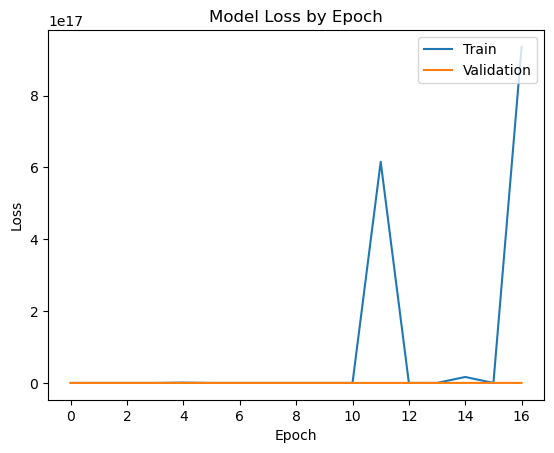

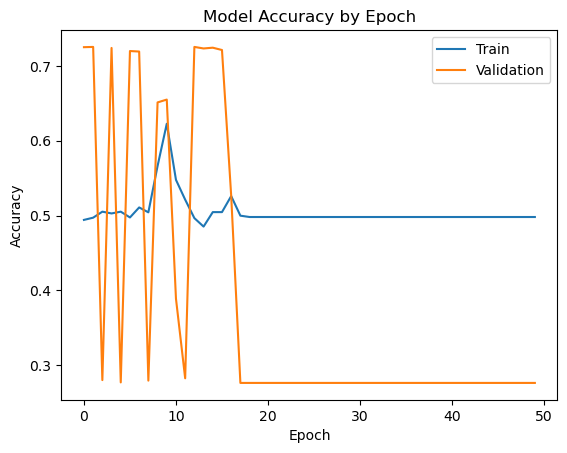

91/91 [==============================] - 28s 284ms/step
[[ 804    0]
 [2107    0]]


/Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

           0       0.28      1.00      0.43       804
           1       0.00      0.00      0.00      2107

    accuracy                           0.28      2911
   macro avg       0.14      0.50      0.22      2911
weighted avg       0.08      0.28      0.12      2911

F1 Score: 0.0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions using the best model (with best weights)
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)  # Using 0.5 as the threshold for binary classification

# Evaluating the best-performing model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")


### Save best model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path to save the best model
best_model_path = 'best_model.h5'

# Modify the ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    best_model_path,            # Filepath to save the model
    monitor='val_loss',         # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='min',                 # Save when 'val_loss' is minimized
    verbose=1                   # Display message when saving
)

# Update the callbacks list to include ModelCheckpoint
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Training with the updated callbacks list
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,  # Using the updated callbacks list
    verbose=1
)


In [9]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-05 12:20:09.697005
